# LG3 token dominance inspection (top code id)

This notebook finds the most frequent token id and visualizes where it dominates in time.
It uses SMARTCARE per-unit data (unit 1, 4, 6) and a trained LG3 VQ-VAE.


In [29]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('../..'))

# Paths
LG3_VQVAE_CKPT = '../saved_models/CD64_CW256_CF4_BS2048_ITR15000/checkpoints/final_model.pth'
UNIT_IDS = [1, 4, 6]
UNIT_ROOT = os.path.abspath(os.path.join('..', 'data', 'processed', 'smartcare_units'))

SEQ_LEN = 96
SAMPLE_SEQS = 2000  # per unit
BATCH_SIZE = 256

FEATURE_NAME = 'Power'  # feature to plot (must exist in unit csv)


## 1) Load model and helpers


In [30]:
from lg3.lib.models.revin import RevIN

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = torch.load(LG3_VQVAE_CKPT, weights_only=False).to(device).eval()
compression_factor = getattr(model, 'compression_factor', 4)

def build_sequences(values, seq_len):
    total = len(values)
    max_start = total - seq_len + 1
    if max_start <= 0:
        return None
    x = np.empty((max_start, seq_len, values.shape[1]), dtype=np.float32)
    for i in range(max_start):
        x[i] = values[i : i + seq_len]
    return x

def time2codes(revin_data, compression_factor, vqvae_encoder, vqvae_quantizer):
    bs = revin_data.shape[0]
    nvar = revin_data.shape[1]
    t_len = revin_data.shape[2]
    compressed_time = int(t_len / compression_factor)
    with torch.no_grad():
        flat_revin = revin_data.reshape(-1, t_len)
        latent = vqvae_encoder(flat_revin.to(torch.float), compression_factor)
        vq_loss, quantized, perplexity, embedding_weight, encoding_indices, encodings = vqvae_quantizer(latent)
        code_ids = encoding_indices.view(bs, nvar, compressed_time)
    return code_ids.detach().cpu().numpy()

def encode_sequences(x, revin_layer):
    # x: (B, T, S)
    x_t = torch.tensor(x, dtype=torch.float32, device=device)
    x_norm = revin_layer(x_t, 'norm')
    code_ids = time2codes(x_norm.permute(0, 2, 1), compression_factor, model.encoder, model.vq)
    return code_ids


## 2) Collect code usage and find top id


Top code id: 115 count: 1168074 total: 2880000


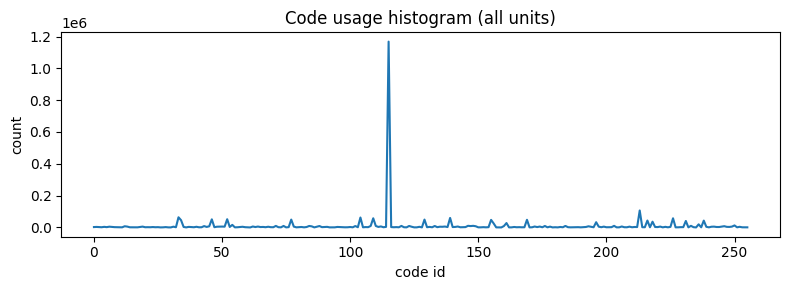

In [31]:
all_codes = []
unit_meta = {}

for unit_id in UNIT_IDS:
    unit_path = os.path.join(UNIT_ROOT, f'unit_{unit_id}', 'lg3_train.csv')
    if not os.path.exists(unit_path):
        print('Missing:', unit_path)
        continue
    df = pd.read_csv(unit_path, index_col=0, parse_dates=True)
    df = df.select_dtypes(include=[np.number]).dropna(how='any')
    if FEATURE_NAME not in df.columns:
        raise ValueError(f'{FEATURE_NAME} not found in {unit_path}')

    x = build_sequences(df.values, SEQ_LEN)
    if x is None:
        print('Not enough data for unit', unit_id)
        continue

    # sample sequences for speed
    if len(x) > SAMPLE_SEQS:
        idx = np.random.choice(len(x), size=SAMPLE_SEQS, replace=False)
        x = x[idx]
        ts = df.index[idx + SEQ_LEN - 1]
    else:
        ts = df.index[SEQ_LEN - 1:]

    revin = RevIN(num_features=x.shape[2], affine=False, subtract_last=False).to(device)

    # batch encode
    codes = []
    for i in range(0, len(x), BATCH_SIZE):
        batch = x[i:i+BATCH_SIZE]
        codes.append(encode_sequences(batch, revin))
    code_ids = np.concatenate(codes, axis=0)

    all_codes.append(code_ids)
    unit_meta[unit_id] = {'timestamps': ts, 'codes': code_ids, 'values': df}

if not all_codes:
    raise RuntimeError('No codes collected')

flat_codes = np.concatenate([c.reshape(-1) for c in all_codes], axis=0)
counts = np.bincount(flat_codes)
top_id = int(np.argmax(counts))
print('Top code id:', top_id, 'count:', counts[top_id], 'total:', counts.sum())

plt.figure(figsize=(8, 3))
plt.plot(counts)
plt.title('Code usage histogram (all units)')
plt.xlabel('code id')
plt.ylabel('count')
plt.tight_layout()
plt.show()


## 3) Visualize top-id dominance over time
For each unit, compute the fraction of top-id tokens per sequence and plot over time.


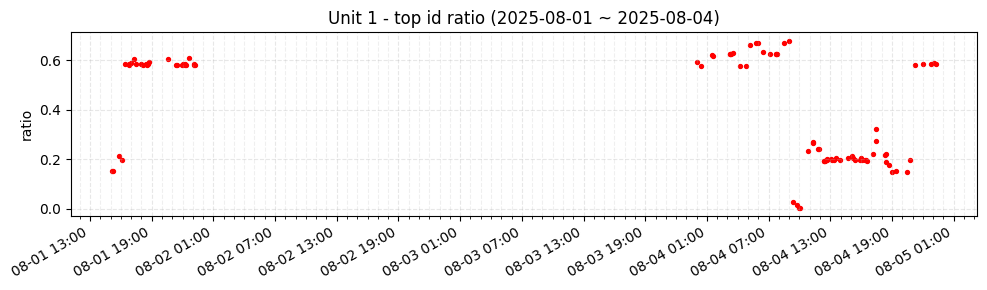

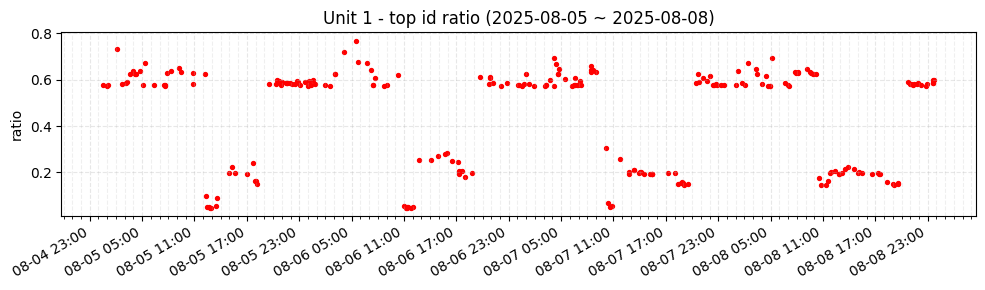

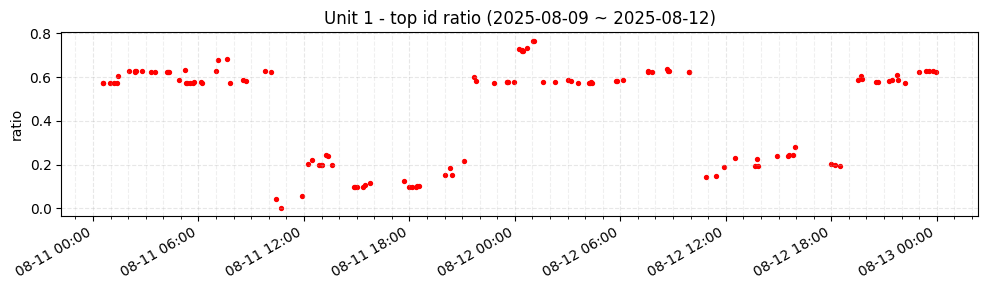

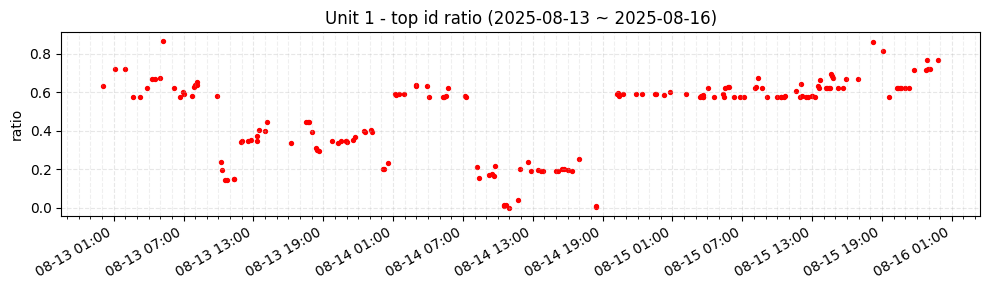

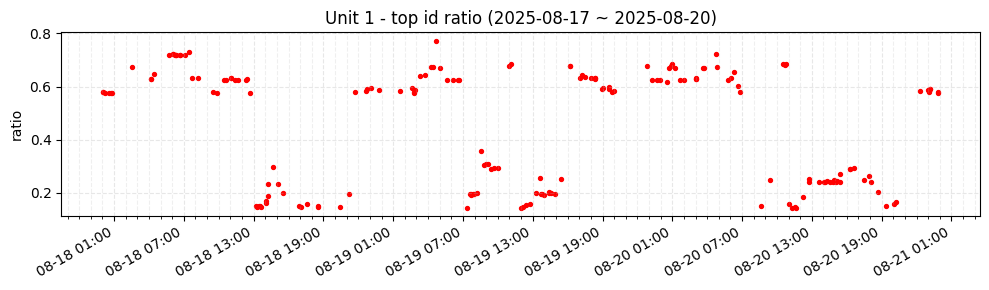

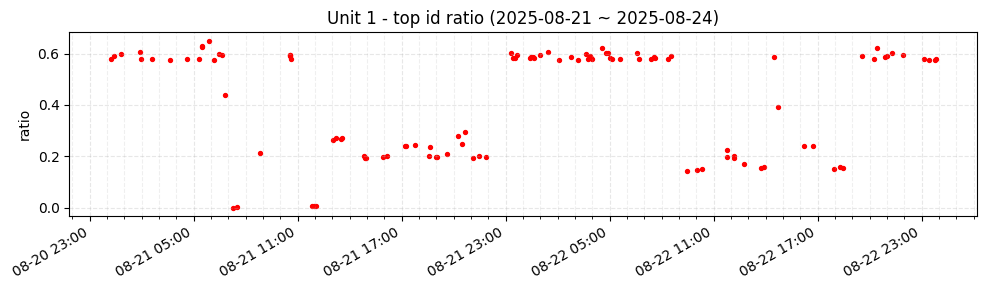

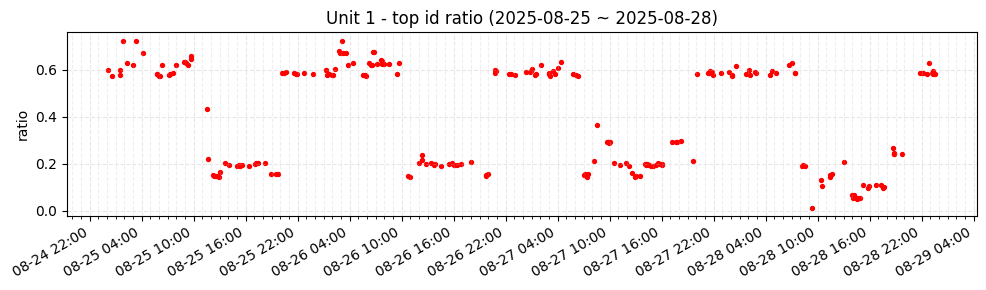

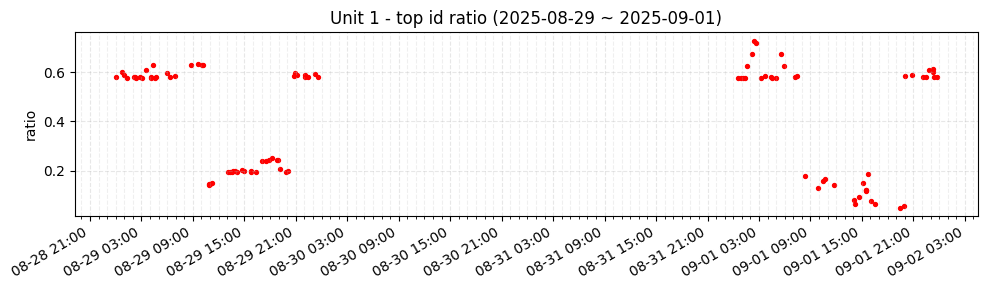

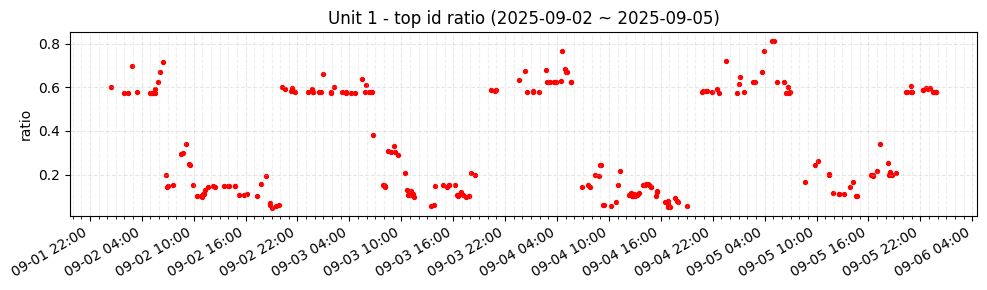

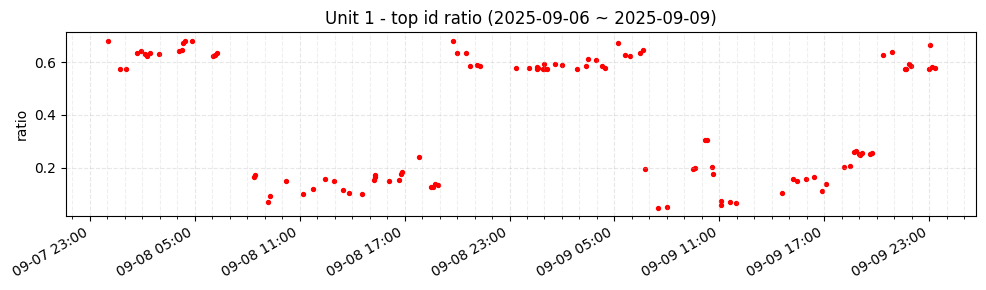

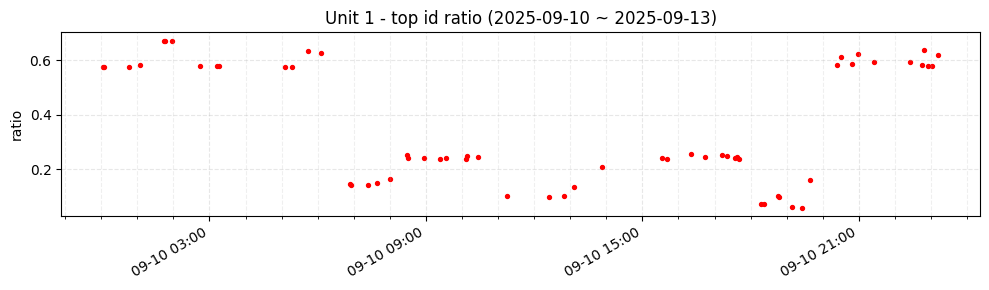

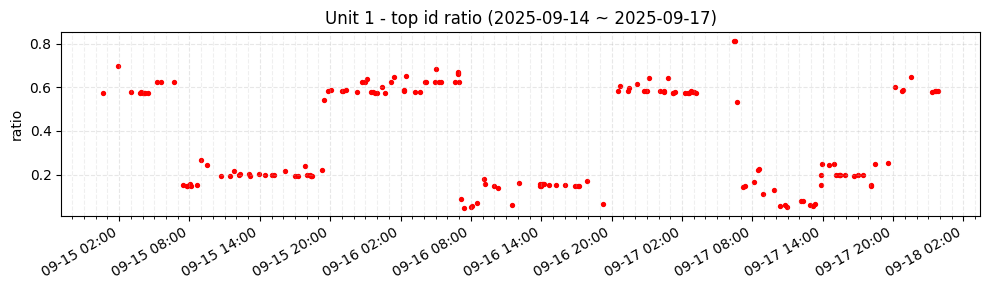

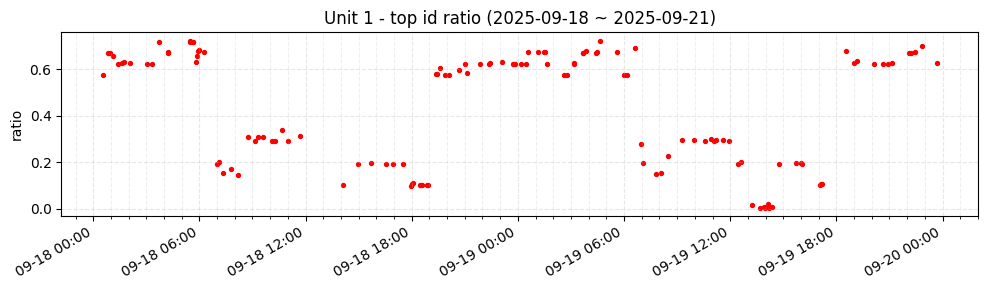

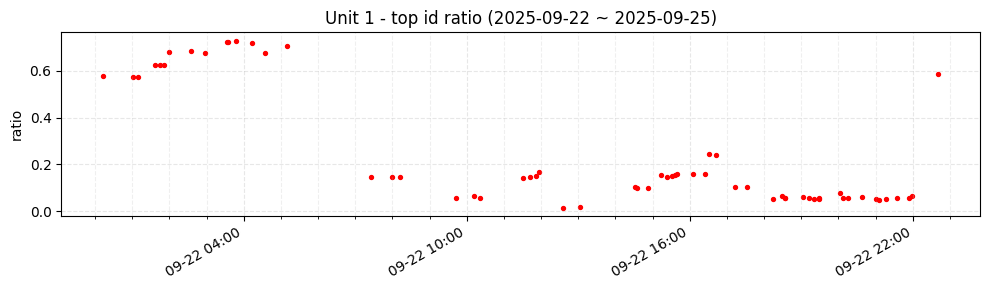

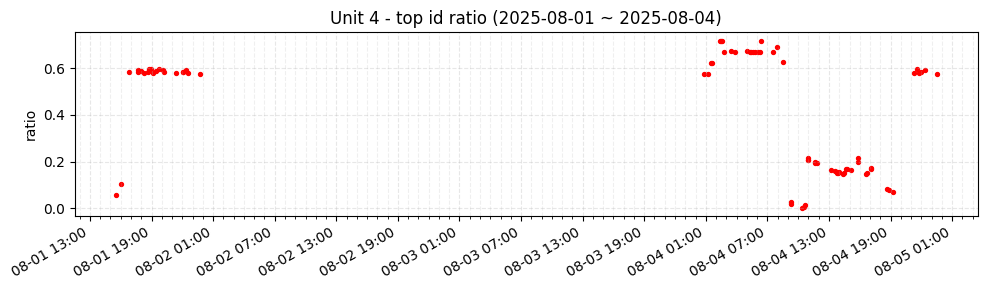

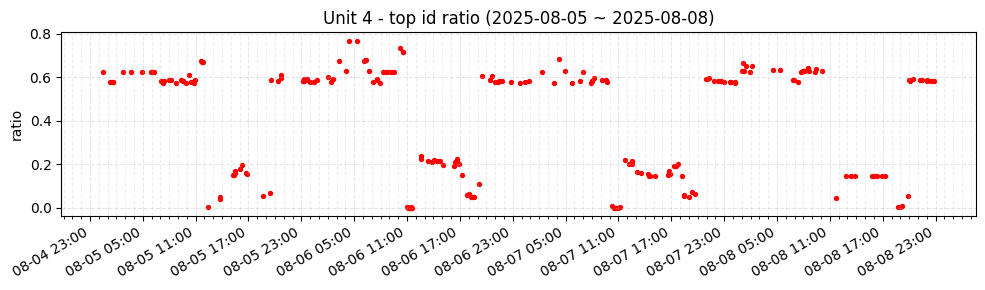

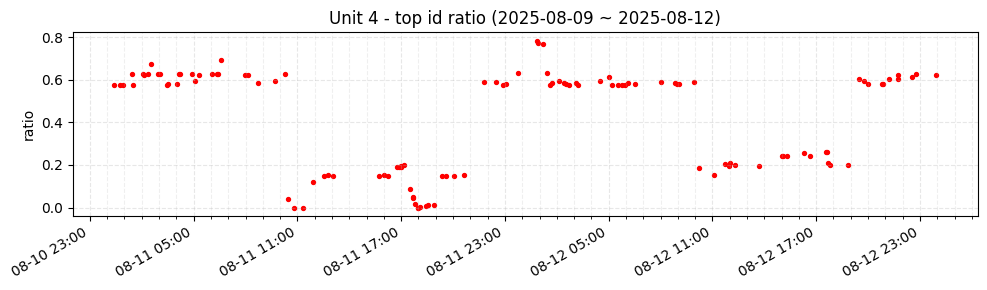

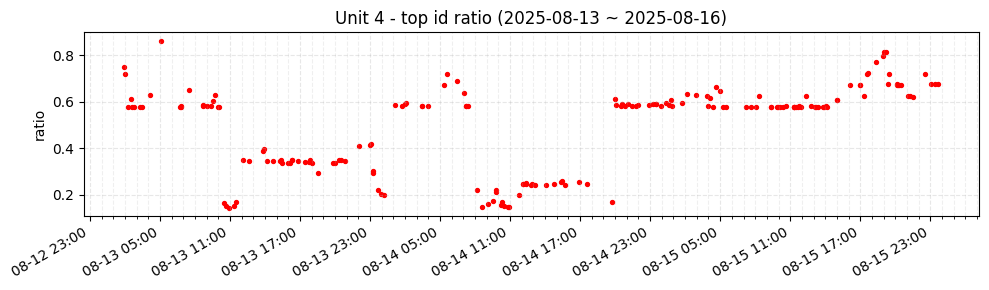

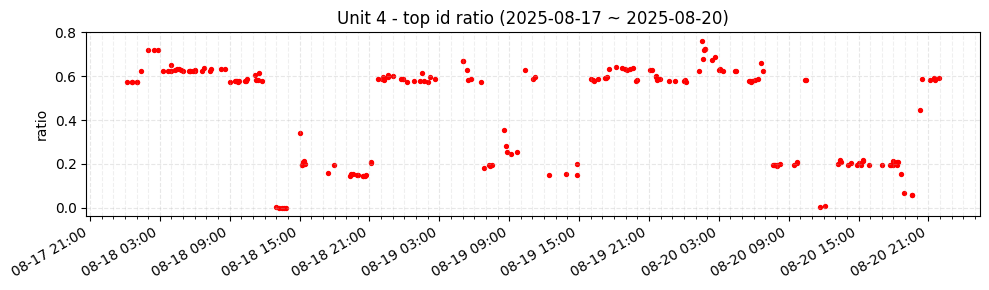

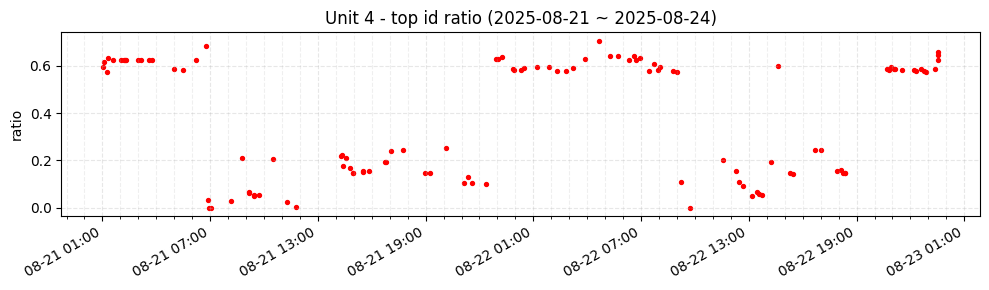

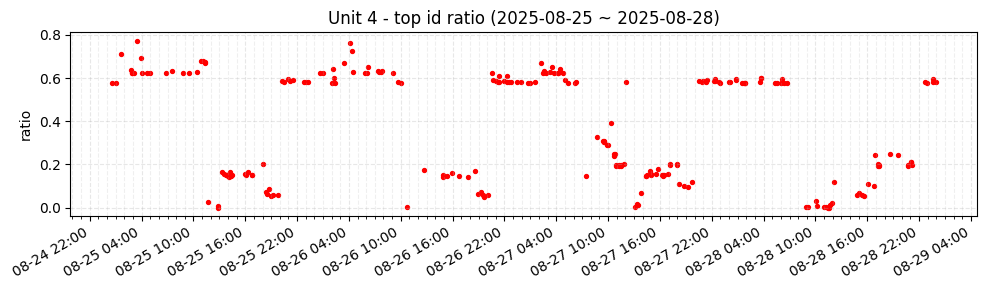

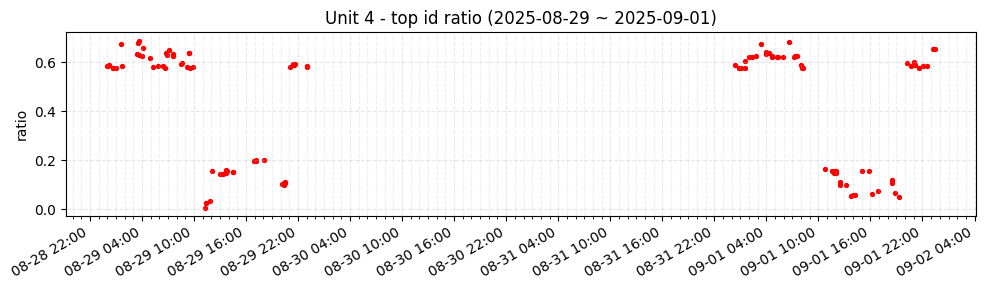

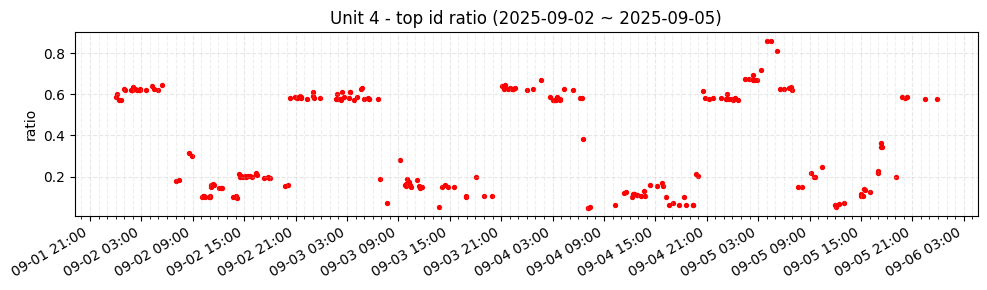

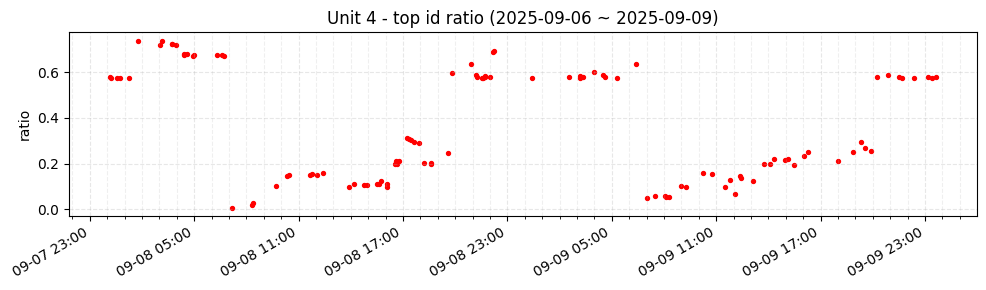

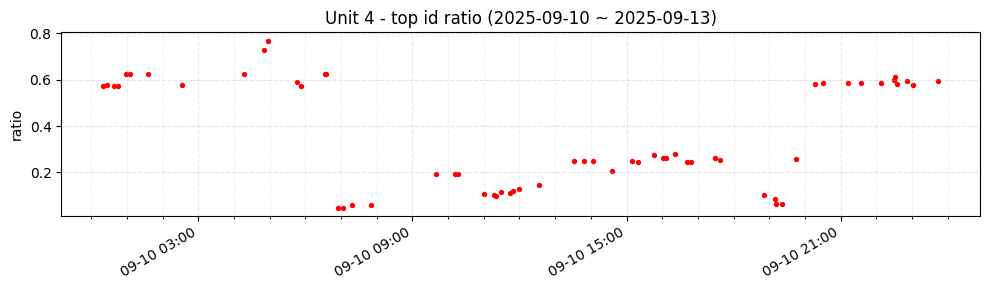

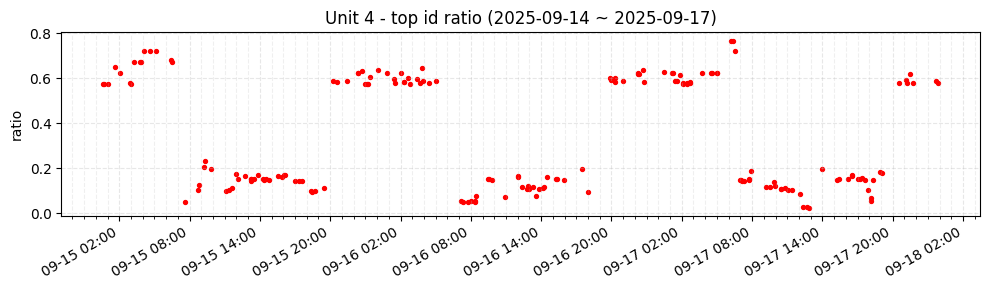

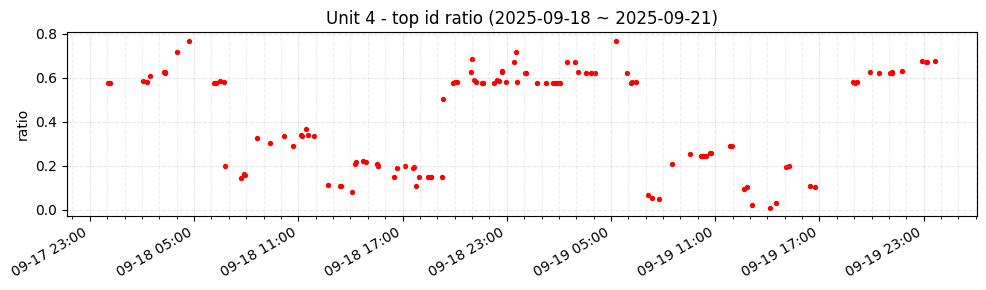

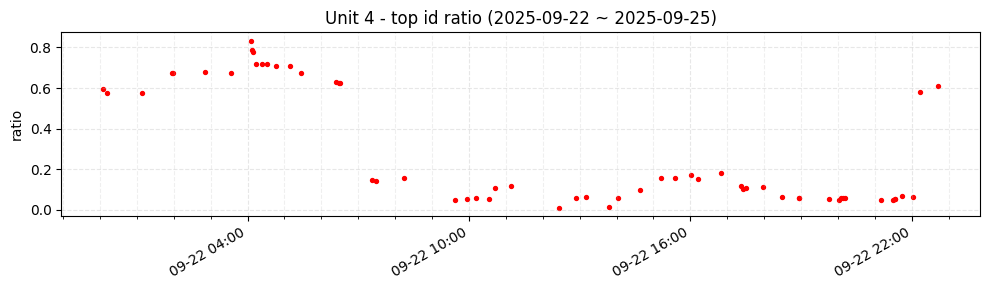

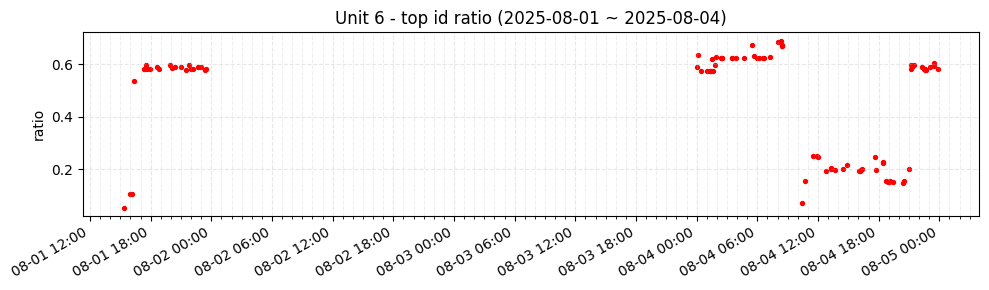

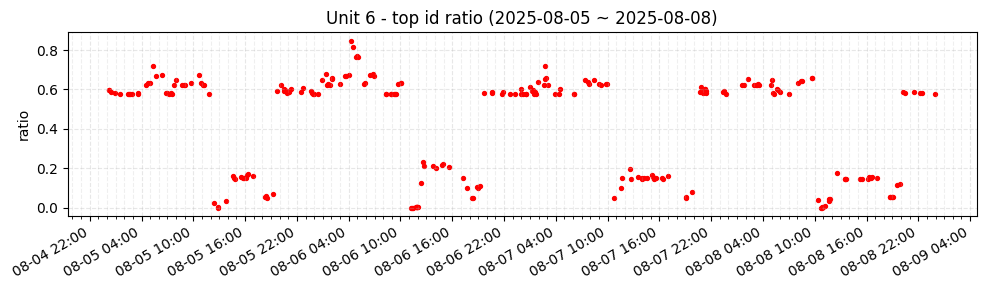

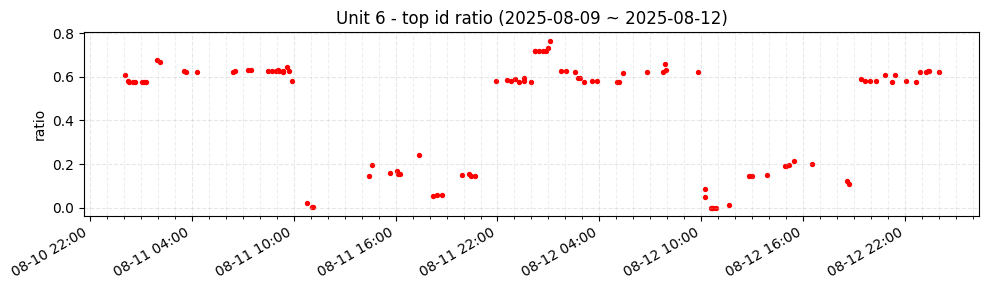

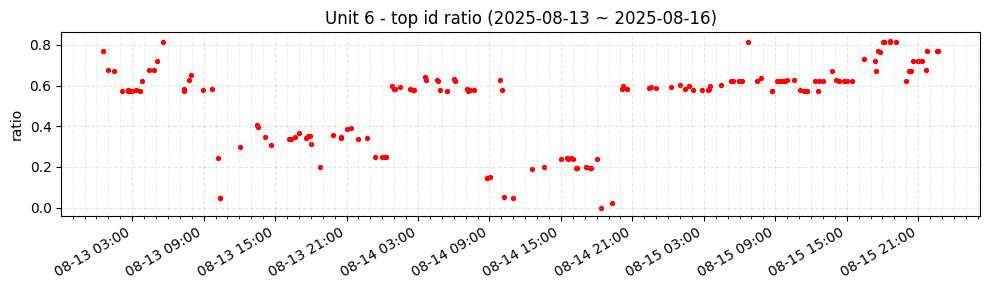

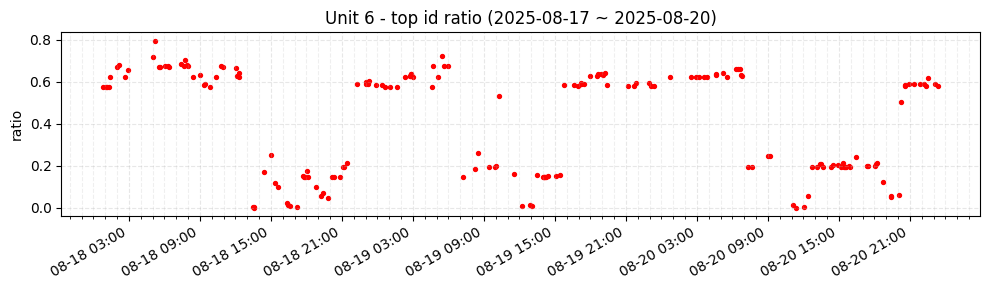

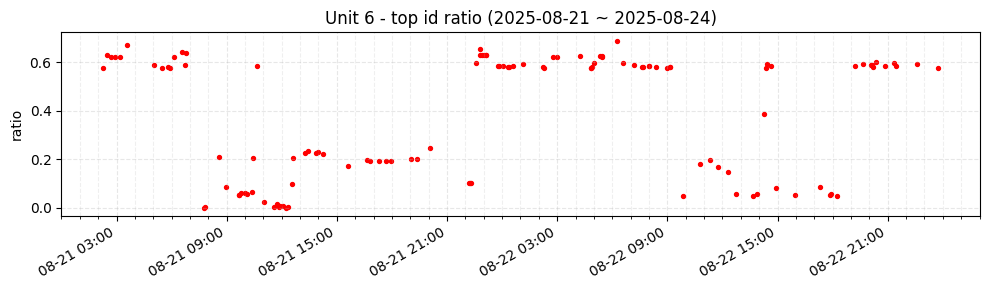

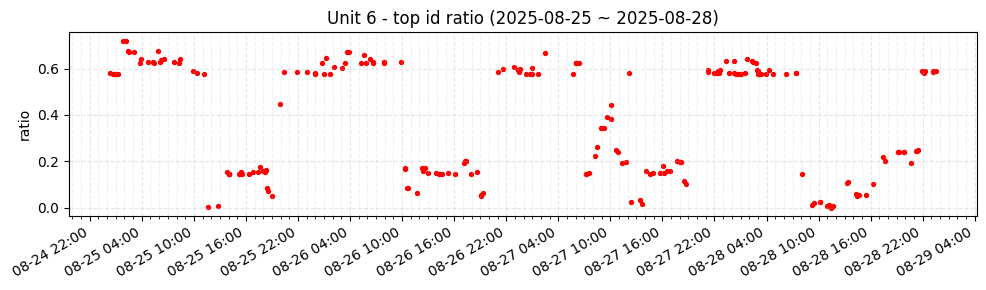

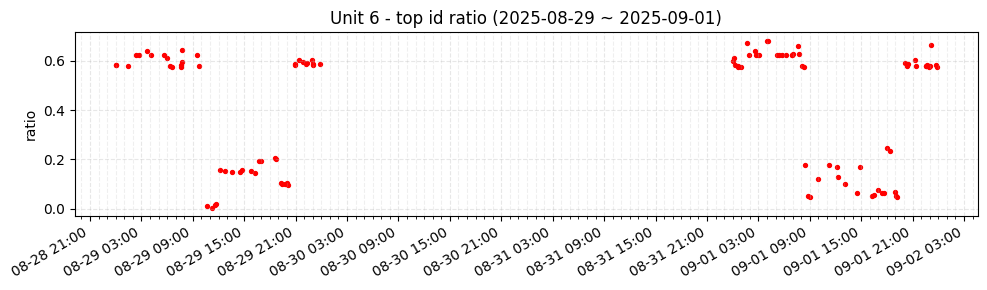

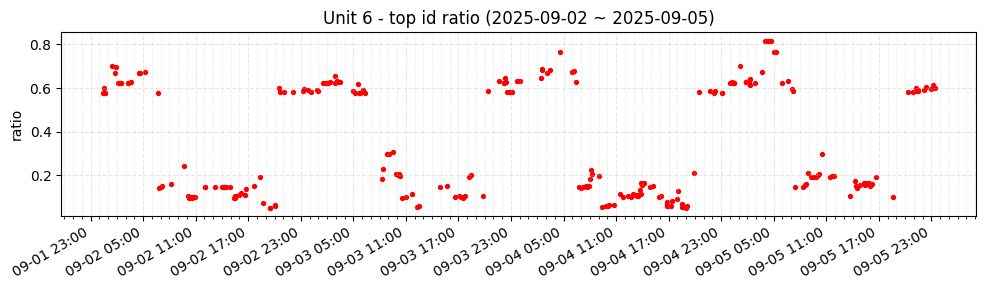

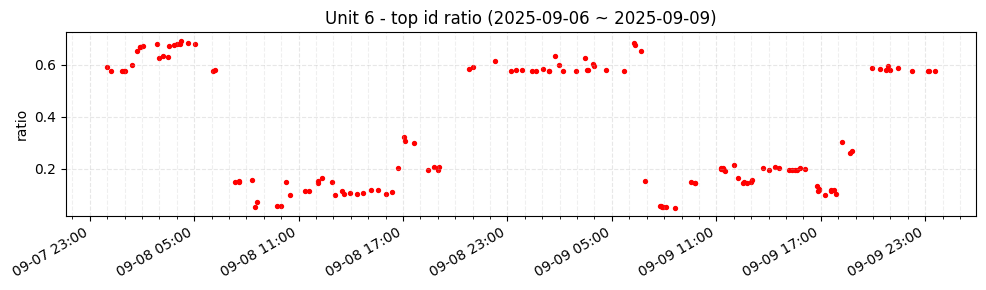

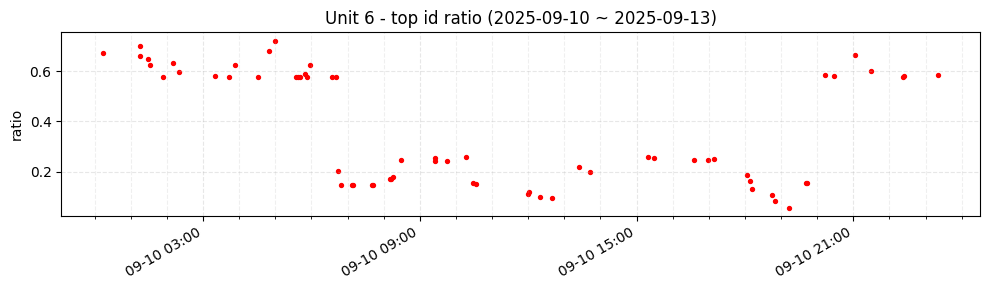

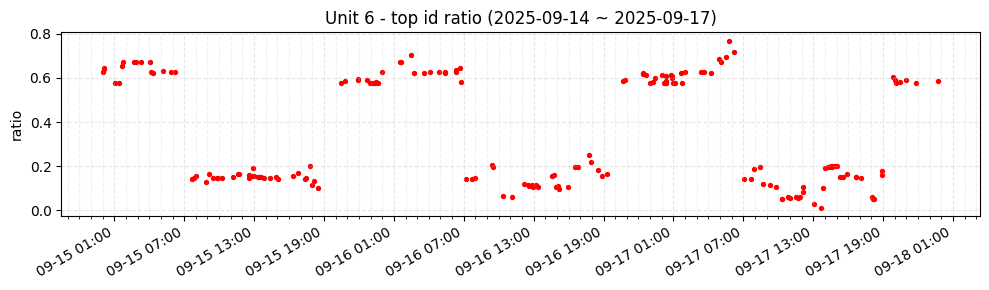

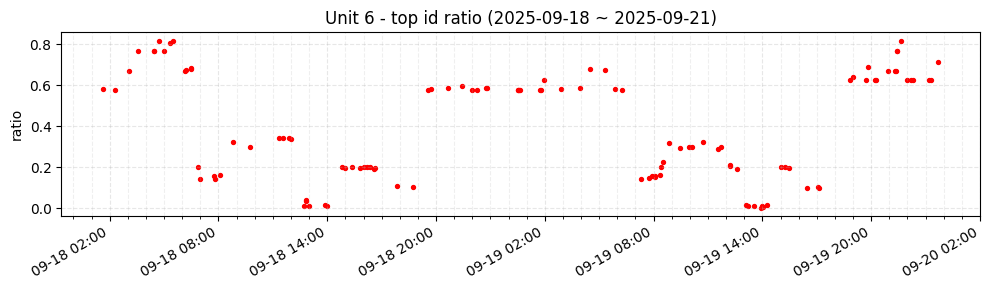

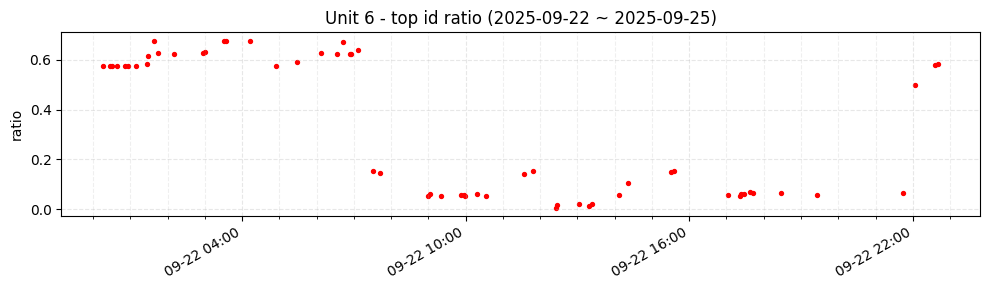

In [32]:
import matplotlib.dates as mdates
def top_id_ratio(code_ids, top_id):
    # code_ids shape: (B, S, Tcomp)
    total = code_ids.shape[1] * code_ids.shape[2]
    hits = (code_ids == top_id).sum(axis=(1, 2))
    return hits / total

def plot_ratio_scatter(ts, ratios, unit_id):
    # Plot in 4-day windows
    start = ts.min().normalize()
    end = ts.max().normalize()
    window = pd.Timedelta(days=4)
    cur = start
    
    while cur <= end:
        nxt = cur + window
        mask = (ts >= cur) & (ts < nxt)
        
        if mask.any():
            plt.figure(figsize=(10, 3))
            plt.scatter(ts[mask], ratios[mask], s=8, color='red')
            
            ax = plt.gca()
            
            # 1. 포맷 및 간격 설정
            ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
            ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
            
            # 2. 그리드 설정
            ax.grid(True, which='major', axis='both', linestyle='--', alpha=0.3)
            ax.grid(True, which='minor', axis='both', linestyle='--', alpha=0.2)
            
            # 3. 레이블 회전 및 정렬 (핵심!)
            # ha='right'를 해야 날짜 끝부분이 눈금에 맞춰집니다.
            # plt.xticks(rotation=45, ha='right') 
            plt.gcf().autofmt_xdate()
            
            # 만약 폰트를 줄이고 싶다면 아래처럼 fontsize를 추가하세요
            # plt.xticks(rotation=45, ha='right', fontsize=8) 

            plt.title(f'Unit {unit_id} - top id ratio ({cur.date()} ~ {(nxt - pd.Timedelta(days=1)).date()})')
            plt.ylabel('ratio')
            
            plt.tight_layout() # 여백 자동 조정
            plt.show()
            
        cur = nxt

for unit_id, meta in unit_meta.items():
    ratios = top_id_ratio(meta['codes'], top_id)
    ts = pd.to_datetime(meta['timestamps'])
    plot_ratio_scatter(ts, ratios, unit_id)


## 4) Overlay top-id spikes with raw feature (single unit)
We highlight sequences where top-id ratio is high.


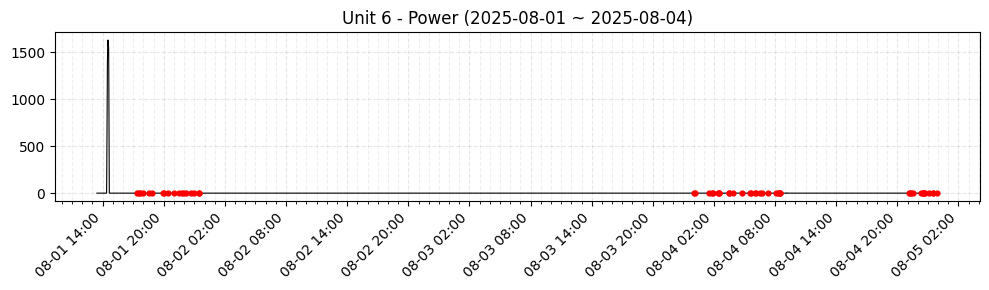

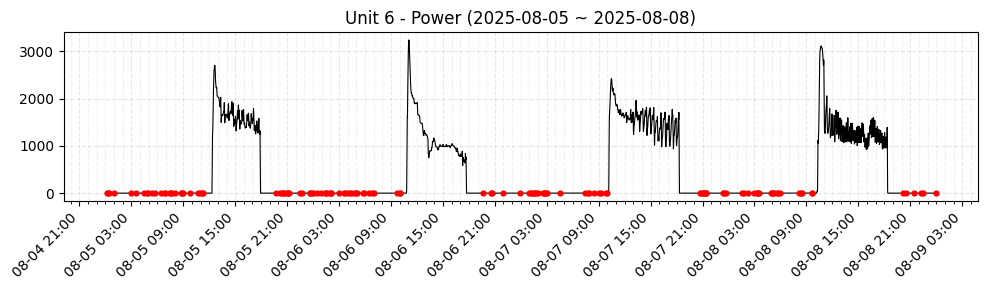

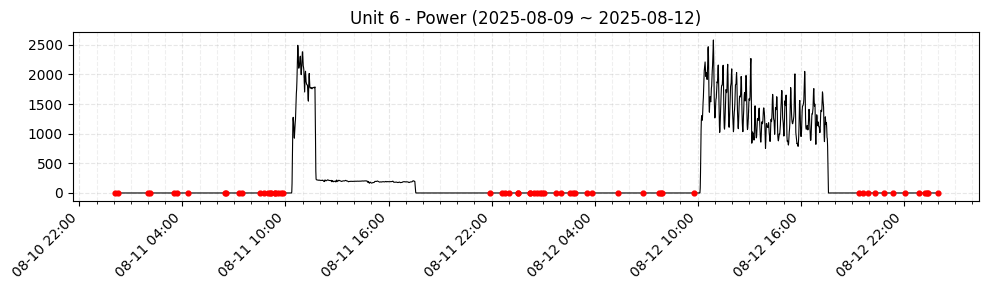

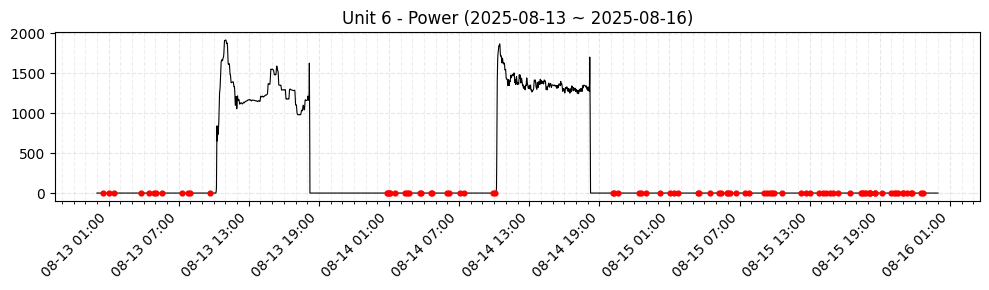

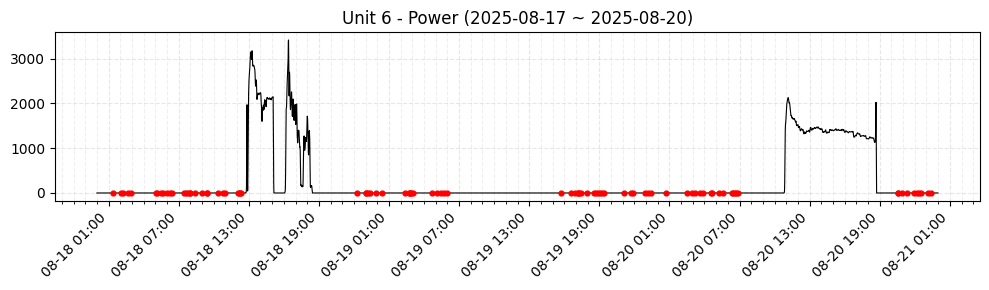

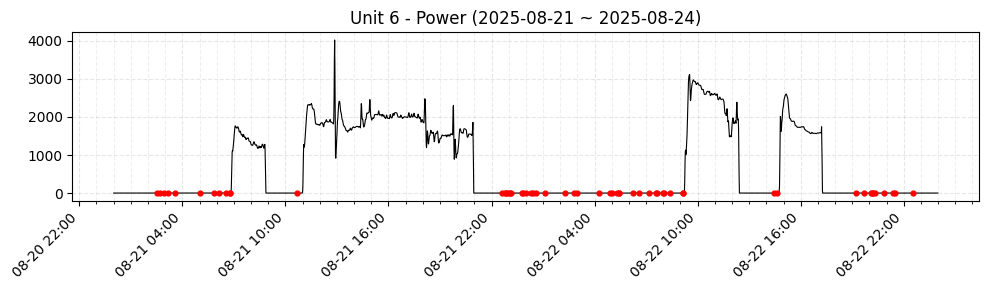

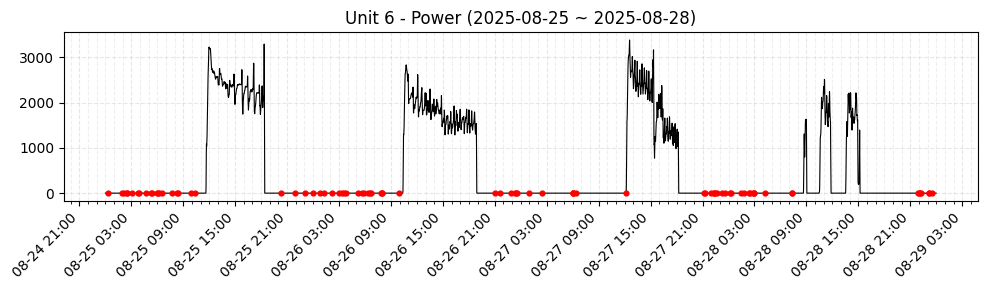

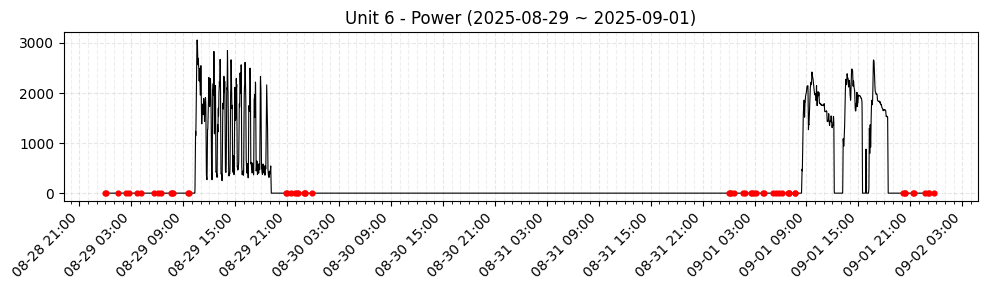

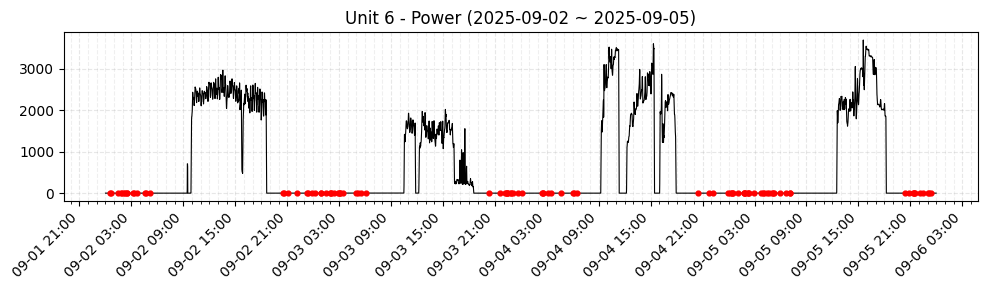

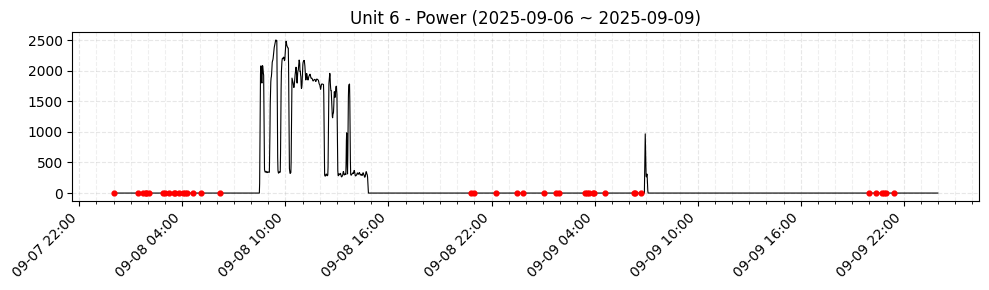

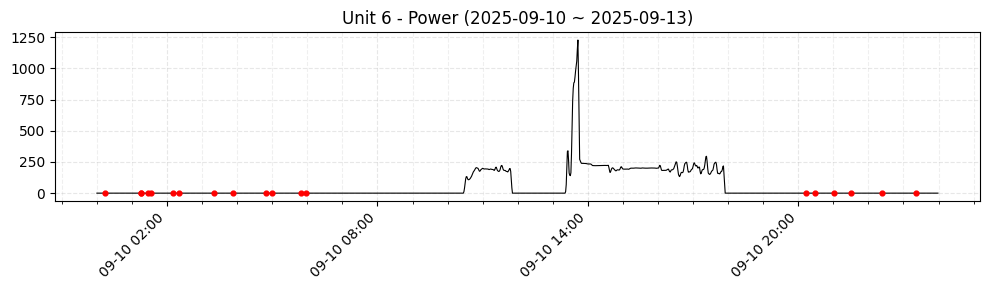

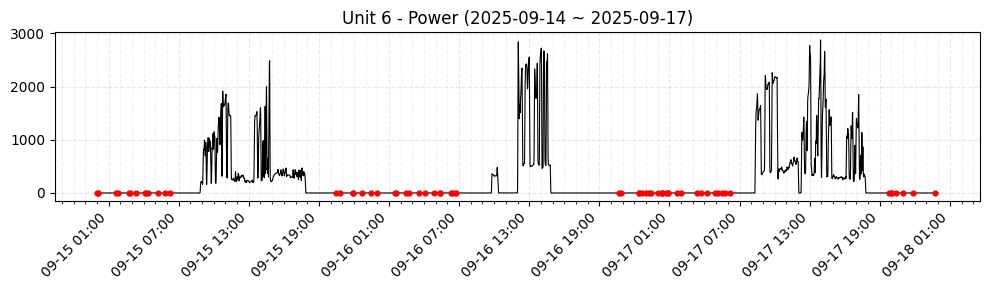

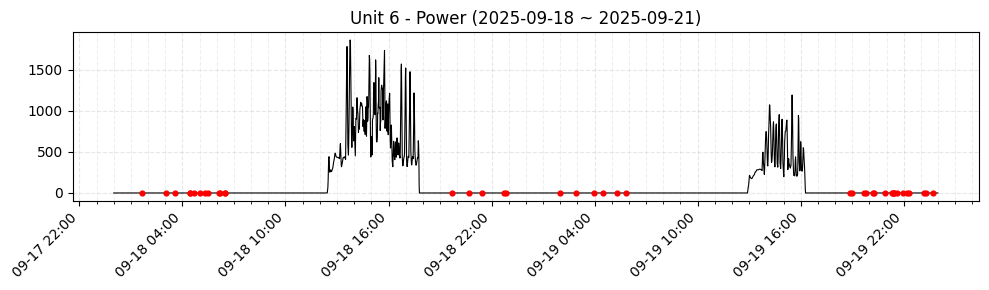

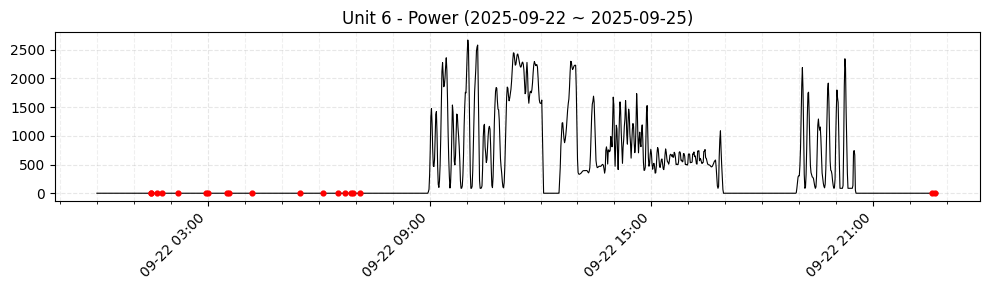

: 

In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# (기존 데이터 준비 코드는 그대로 유지)
unit_id = UNIT_IDS[2]
meta = unit_meta[unit_id]
ratios = top_id_ratio(meta['codes'], top_id)
ts = pd.to_datetime(meta['timestamps'])

threshold = np.quantile(ratios, 0.55)
high = ratios >= threshold

feature_series = meta['values'][FEATURE_NAME]

# Plot in 4-day windows
start = feature_series.index.min().normalize()
end = feature_series.index.max().normalize()
window = pd.Timedelta(days=4)
cur = start

while cur <= end:
    nxt = cur + window
    seg = feature_series[(feature_series.index >= cur) & (feature_series.index < nxt)]
    
    if len(seg) == 0:
        cur = nxt
        continue
        
    plt.figure(figsize=(10, 3))
    plt.plot(seg.index, seg.values, color='black', linewidth=0.8)
    
    ax = plt.gca()
    
    # 1. X축 눈금 및 포맷 설정 (한 번만 작성)
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
    
    # 2. 그리드 설정
    ax.grid(True, which='major', axis='both', linestyle='--', alpha=0.3)
    ax.grid(True, which='minor', axis='both', linestyle='--', alpha=0.2)
    
    # 3. 레이블 회전 설정 (핵심 수정 사항)
    # rotation=0을 제거하고 45도 회전 및 오른쪽 정렬만 남김
    plt.xticks(rotation=45, ha='right')
    
    plt.title(f'Unit {unit_id} - {FEATURE_NAME} ({cur.date()} ~ {(nxt - pd.Timedelta(days=1)).date()})')

    # mark high-ratio windows (as points)
    mask = (ts >= cur) & (ts < nxt)
    if mask.any():
        # 데이터 매칭을 위한 인덱스 처리
        valid_indices = high[mask]
        target_ts = ts[mask][valid_indices]
        # feature_series에 해당 타임스탬프가 있는지 확인 후 플롯 (Safety check 권장)
        try:
            target_vals = seg.reindex(target_ts).values
            plt.scatter(target_ts, target_vals, color='red', s=12, zorder=5)
        except Exception as e:
            print(f"Skipping scatter due to index mismatch: {e}")

    plt.tight_layout()
    plt.show()
    
    cur = nxt

## 5) What pattern does the top token represent?
We decode a sequence made entirely of the top id and plot its reconstructed waveform.


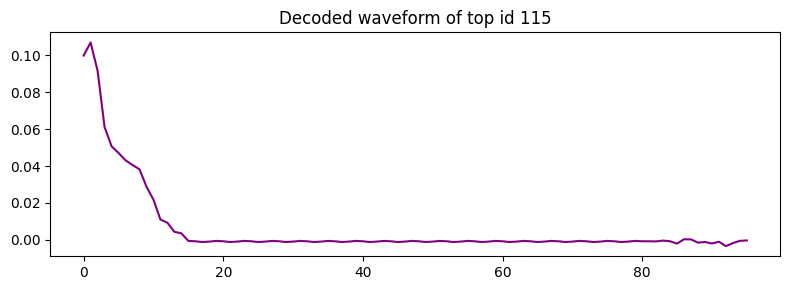

In [34]:
# Decode a pure top-id sequence to visualize its waveform
codebook = model.vq._embedding.weight.detach().cpu().numpy()
code_dim = codebook.shape[1]
tcomp = SEQ_LEN // compression_factor

# Build a quantized tensor: [B, code_dim, tcomp]
vec = codebook[top_id]  # (code_dim,)
quantized = np.tile(vec.reshape(1, code_dim, 1), (1, 1, tcomp))
q_t = torch.tensor(quantized, dtype=torch.float32, device=device)
with torch.no_grad():
    recon = model.decoder(q_t, compression_factor).detach().cpu().numpy()[0]

plt.figure(figsize=(8, 3))
plt.plot(recon, color='purple')
plt.title(f'Decoded waveform of top id {top_id}')
plt.tight_layout()
plt.show()


Optional: compare with average of high-ratio sequences (single unit).


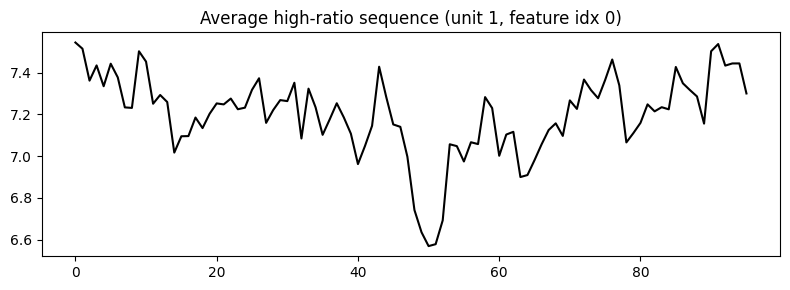

In [35]:
unit_id = UNIT_IDS[0]
meta = unit_meta[unit_id]
ratios = top_id_ratio(meta['codes'], top_id)
ts = pd.to_datetime(meta['timestamps'])

# Rebuild sequences for this unit to compute mean pattern
df = meta['values']
values = df.select_dtypes(include=[np.number]).values
x = build_sequences(values, SEQ_LEN)
if x is not None:
    # align x length with ratios length
    max_len = min(len(x), len(ratios))
    x = x[:max_len]
    ratios = ratios[:max_len]
    high = ratios >= np.quantile(ratios, 0.95)
    mean_pattern = x[high].mean(axis=0)
    # plot one feature (first column)
    plt.figure(figsize=(8, 3))
    plt.plot(mean_pattern[:, 0], color='black')
    plt.title(f'Average high-ratio sequence (unit {unit_id}, feature idx 0)')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough data to compute mean pattern')
